# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine learning is a fitting solution in this case because it enables the company to analyze past flight data and uncover patterns linked to delays, especially those caused by weather. By training on historical data, a predictive model can estimate the likelihood of a flight delay due to weather, using factors like departure time, origin, destination, and season. This insight would enhance the customer experience by notifying travelers of possible delays before booking, helping them make more informed choices. In this way, machine learning offers a proactive, data-driven approach that goes beyond the capabilities of traditional rule-based systems, which may struggle with the complex mix of factors that lead to delays. Another important thing is ML can handle large dataset which some softwares, such as Ms. Excel or Word could not do it properly

### 2. Formulate the business problem, success metrics, and desired ML output.

- Business Problem: The travel booking website wants to improve customer satisfaction by alerting travelers about potential weather-related flight delays when booking flights at the busiest airports in the U.S.

- Success Metrics: The ML model’s effectiveness can be evaluated through metrics like accuracy, precision, recall, and F1 score for classifying delays. Since correctly predicting delays is crucial for customer satisfaction, recall (to identify as many delayed flights as possible) and precision (to minimize false delay alerts) are especially important.

- Desired ML Output: The goal is a binary classification model (delay or no delay) that predicts whether a flight will be delayed by more than 15 minutes due to weather conditions.

### 3. Identify the type of ML problem you’re dealing with.

This ML model uses supervised learning to solve a classification problem with the objective of categorizing flights into two groups: delayed (by more than 15 minutes) and not delayed. Given that the target variable (delay) is binary (0 and 1), this problem can be addressed using supervised classification algorithms such as logistic regression, decision trees, random forests, or other models well-suited for binary classification tasks.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [2]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'compressed_file/data_compressed.zip'
base_path = '.'
csv_base_path = 'data'

!mkdir {csv_base_path}

#### Extract CSV files from ZIP files

In [3]:
import os
import shutil
from zipfile import ZipFile

def zip2csv(zipFile_name, file_path):
    """
    Extract CSVs from ZIP files, including handling nested ZIP files.
    zipFile_name: name of the zip file
    file_path: name of the folder to store csv files
    """
    try:
        with ZipFile(zipFile_name, 'r') as z:
            print(f'Extracting {zipFile_name}')
            z.extractall(path=file_path)  # Extract all files from the current ZIP
            
            # Check if there are any inner ZIP files or subfolders
            for inner_file in z.namelist():
                inner_file_path = os.path.join(file_path, inner_file)
                
                # If an extracted file is a ZIP file, extract it
                if inner_file.endswith('.zip'):
                    with ZipFile(inner_file_path, 'r') as inner_zip:
                        print(f'Extracting {inner_file}')
                        inner_zip.extractall(file_path)  # Extract inner ZIP into the same folder
                    
                    # Optionally, remove the inner ZIP file after extracting
                    os.remove(inner_file_path)
                
                # If the inner file is a directory, handle its contents
                elif os.path.isdir(inner_file_path):
                    for root, dirs, files in os.walk(inner_file_path):
                        for file in files:
                            # Move files to the main target folder (flatten structure)
                            full_file_path = os.path.join(root, file)
                            os.rename(full_file_path, os.path.join(file_path, file))
                    
                    # Remove the empty subdirectory after moving files
                    os.rmdir(inner_file_path)

        # After everything is extracted, remove the data_compressed folder if it exists
        compressed_folder = os.path.join(file_path, 'data_compressed')
        if os.path.exists(compressed_folder) and os.path.isdir(compressed_folder):
            shutil.rmtree(compressed_folder)
            print(f"Deleted folder: {compressed_folder}")

    except Exception as e:
        print(f'zip2csv failed for {zipFile_name} with error: {e}')

# Example call to the function
zip2csv(zip_path, csv_base_path)

print("Files Extracted")


Extracting compressed_file/data_compressed.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987

In [4]:
csv_files_count = len([f for f in os.listdir('./data') if f.endswith('.csv')])
print("Number of extracted CSV files:", csv_files_count)



Number of extracted CSV files: 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [5]:

from IPython.display import HTML 
with open(f"{csv_base_path}/readme.html", "r") as file:
    html_content = file.read()
    display(HTML(html_content))

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [6]:
# Load a single dataset On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9 to get a sense of the data
df_temp = pd.read_csv('./data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv')


**Question**: Print the row and column length in the dataset, and print the column names.

In [7]:
# Print the rows and columns
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [8]:
# Print the first 10 rows of the dataset
print(df_temp.head(10))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2018        3      9           3          1  2018-09-03                9E   
1  2018        3      9           9          7  2018-09-09                9E   
2  2018        3      9          10          1  2018-09-10                9E   
3  2018        3      9          13          4  2018-09-13                9E   
4  2018        3      9          14          5  2018-09-14                9E   
5  2018        3      9          16          7  2018-09-16                9E   
6  2018        3      9          17          1  2018-09-17                9E   
7  2018        3      9          20          4  2018-09-20                9E   
8  2018        3      9          21          5  2018-09-21                9E   
9  2018        3      9          23          7  2018-09-23                9E   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     20363                

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [9]:
# Print all the column names using .columns
print('The column names are:')
print('#########')
for col in df_temp.columns:
    print(col)


The column names are:
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1T

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [10]:
# Enter your code here# Finding columns with 'Del' in the column name (for delay data)
delay_columns = [col for col in df_temp.columns if 'Del' in col]
print(f'Columns with "Del" in the name: {delay_columns}')


Columns with "Del" in the name: ['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [11]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are:", df_temp['Year'].unique())
print("The months covered in this dataset are:", sorted(df_temp['Month'].unique()))
print("The date range for data is:", df_temp['FlightDate'].min(), "to", df_temp['FlightDate'].max())
print("The airlines covered in this dataset are:", df_temp['Reporting_Airline'].unique())
print("The Origin airports covered are:", df_temp['Origin'].unique())
print("The Destination airports covered are:", df_temp['Dest'].unique())

The #rows and #columns are  585749  and  110
The years in this dataset are: [2018]
The months covered in this dataset are: [9]
The date range for data is: 2018-09-01 to 2018-09-30
The airlines covered in this dataset are: ['9E' 'B6' 'WN' 'YV' 'YX' 'EV' 'AA' 'AS' 'DL' 'HA' 'UA' 'F9' 'G4' 'MQ'
 'NK' 'OH' 'OO']
The Origin airports covered are: ['DFW' 'LGA' 'MSN' 'MSP' 'ATL' 'BDL' 'VLD' 'JFK' 'RDU' 'CHS' 'DTW' 'GRB'
 'PVD' 'SHV' 'FNT' 'PIT' 'RIC' 'RST' 'RSW' 'CVG' 'LIT' 'ORD' 'JAX' 'TRI'
 'BOS' 'CWA' 'DCA' 'CHO' 'AVP' 'IND' 'GRR' 'BTR' 'MEM' 'TUL' 'CLE' 'STL'
 'BTV' 'OMA' 'MGM' 'TVC' 'SAV' 'GSP' 'EWR' 'OAJ' 'BNA' 'MCI' 'TLH' 'ROC'
 'LEX' 'PWM' 'BUF' 'AGS' 'CLT' 'GSO' 'BWI' 'SAT' 'PHL' 'TYS' 'ACK' 'DSM'
 'GNV' 'AVL' 'BGR' 'MHT' 'ILM' 'MOT' 'IAH' 'SBN' 'SYR' 'ORF' 'MKE' 'XNA'
 'MSY' 'PBI' 'ABE' 'HPN' 'EVV' 'ALB' 'LNK' 'AUS' 'PHF' 'CHA' 'GTR' 'BMI'
 'BQK' 'CID' 'CAK' 'ATW' 'ABY' 'CAE' 'SRQ' 'MLI' 'BHM' 'IAD' 'CSG' 'CMH'
 'MCO' 'MBS' 'FLL' 'SDF' 'TPA' 'MVY' 'LAS' 'LGB' 'SFO' 'SAN' 'LAX' 'RNO'


**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [12]:
# Count the occurrences of Origin and Destination airports
counts = pd.DataFrame({'Origin': df_temp['Origin'].value_counts(), 
                       'Destination': df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [13]:
# Top 15 Origin airports
print("Top 15 Origin airports:")
print(counts['Origin'].sort_values(ascending=False).head(15))

# Top 15 Destination airports
print("Top 15 Destination airports:")
print(counts['Destination'].sort_values(ascending=False).head(15))


Top 15 Origin airports:
ATL    31525
ORD    28257
DFW    22802
DEN    19807
CLT    19655
LAX    17875
SFO    14332
IAH    14210
LGA    13850
MSP    13349
LAS    13318
PHX    13126
DTW    12725
BOS    12223
SEA    11872
Name: Origin, dtype: int64
Top 15 Destination airports:
ATL    31521
ORD    28250
DFW    22795
DEN    19807
CLT    19654
LAX    17873
SFO    14348
IAH    14203
LGA    13850
MSP    13347
LAS    13322
PHX    13128
DTW    12724
BOS    12227
SEA    11877
Name: Destination, dtype: int64


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

- Yes, with enough details about a flight, it's feasible to predict the likelihood of a delay. By examining factors like departure time, origin and destination airports, airline, season, day of the week, and other relevant variables, a machine learning model can be trained to identify patterns linked to delays.

- Given that the dataset includes historical flight data and delay information, an ML model can learn from these patterns to estimate delay risks for future flights in similar circumstances. Once trained, this classification model can provide informed predictions about potential delays, particularly those influenced by weather and operational factors.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [14]:
import os
import pandas as pd  # Ensure pandas is imported
import time  # Import time to measure execution duration

# Function to combine CSV files
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    file_name: name of the final combined CSV file
    """
    
    # Create an empty DataFrame
    combined_df = pd.DataFrame()

    for file in csv_files:
        try:
            # Read the CSV file
            df = pd.read_csv(file)
            
            # Filter the columns
            df_filter = df[filter_cols]

            # Subset the rows based on the subset values
            for col, values in zip(subset_cols, subset_vals):
                df_filter = df_filter[df_filter[col].isin(values)]
            
        #     # Print shape for debugging
        #     print(f"Shape of df_filter before concatenation: {df_filter.shape}")

            # Concatenate with the combined DataFrame
            combined_df = pd.concat([combined_df, df_filter], ignore_index=True)

        except Exception as e:
            print(f"Failed to process {file}: {e}")

    # Save the combined DataFrame to a CSV file
    combined_df.to_csv(file_name, index=False)
    print(f'CSV files combined and saved to {file_name}')

# Path to the directory containing the CSV files
csv_base_path = './data'

# Create a list of all CSV files in the directory
csv_files = [os.path.join(csv_base_path, file) for file in os.listdir(csv_base_path) if file.endswith('.csv')]

# Define the columns to keep and the subset criteria
filter_cols = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 
               'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 
               'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 
               'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],  # Origin airports
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],  # Destination airports
               ['UA', 'OO', 'WN', 'AA', 'DL']]  # Airlines

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [15]:
# Start timing
start = time.time()

# Call the function with the file paths and save as 'combined_files.csv'
combine_csv(csv_files, filter_cols, subset_cols, subset_vals, f"{csv_base_path}/combined_files.csv")

# Print time taken for the operation
print(f'CSV files merged in {round((time.time() - start) / 60, 2)} minutes')


CSV files combined and saved to ./data/combined_files.csv
CSV files merged in 4.13 minutes


#### Load dataset

Load the combined dataset.

In [16]:
data = pd.read_csv('./data/combined_files.csv')

Print the first 5 records.

In [17]:
# Print the first 5 records of the dataset
print("First 5 records of the dataset:")
print(data.head(5))

First 5 records of the dataset:
   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes 

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [18]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
print("The date range for data is: ", min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))


The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is:  2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [19]:
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True) # Enter your code here

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [20]:
# Check for nulls across all columns
null_counts = data.isnull().sum(axis=0)

# Print the number of null values in each column
print("Number of null values in each column:")
print(null_counts)


Number of null values in each column:
Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [21]:
# Remove NA value in ArrDelay
data = data[~data['ArrDelay'].isnull()]

In [22]:
# Check for missing value again
data.isna().sum()


Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour time format from CRSDepTime.

In [23]:
# Extract the hour of the day in 24-hour time format from 'CRSDepTime'
data['DepHourofDay'] = data['CRSDepTime'] // 100

# Display the first few rows to verify the new column
print(data[['CRSDepTime', 'DepHourofDay']].head())


   CRSDepTime  DepHourofDay
0        2145            21
1         945             9
2        1855            18
3        1634            16
4         700             7


## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

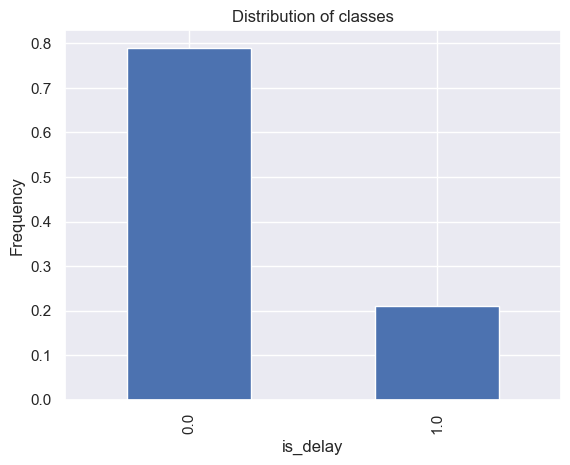

In [24]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

- It’s evident that there’s a notable class imbalance between the "delay" (1.0) and "no delay" (0.0) categories in the dataset. Specifically, the "no delay" category (0.0) is far more prevalent, comprising roughly 80% of the data, while the "delay" category (1.0) represents only about 20%.

- This imbalance could affect model training if not addressed, as many machine learning algorithms may favor the majority class ("no delay") and underperform on the minority class ("delay"). To effectively manage this imbalance, techniques like resampling (either oversampling or undersampling), adjusting class weights, or using specialized evaluation metrics may be necessary.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

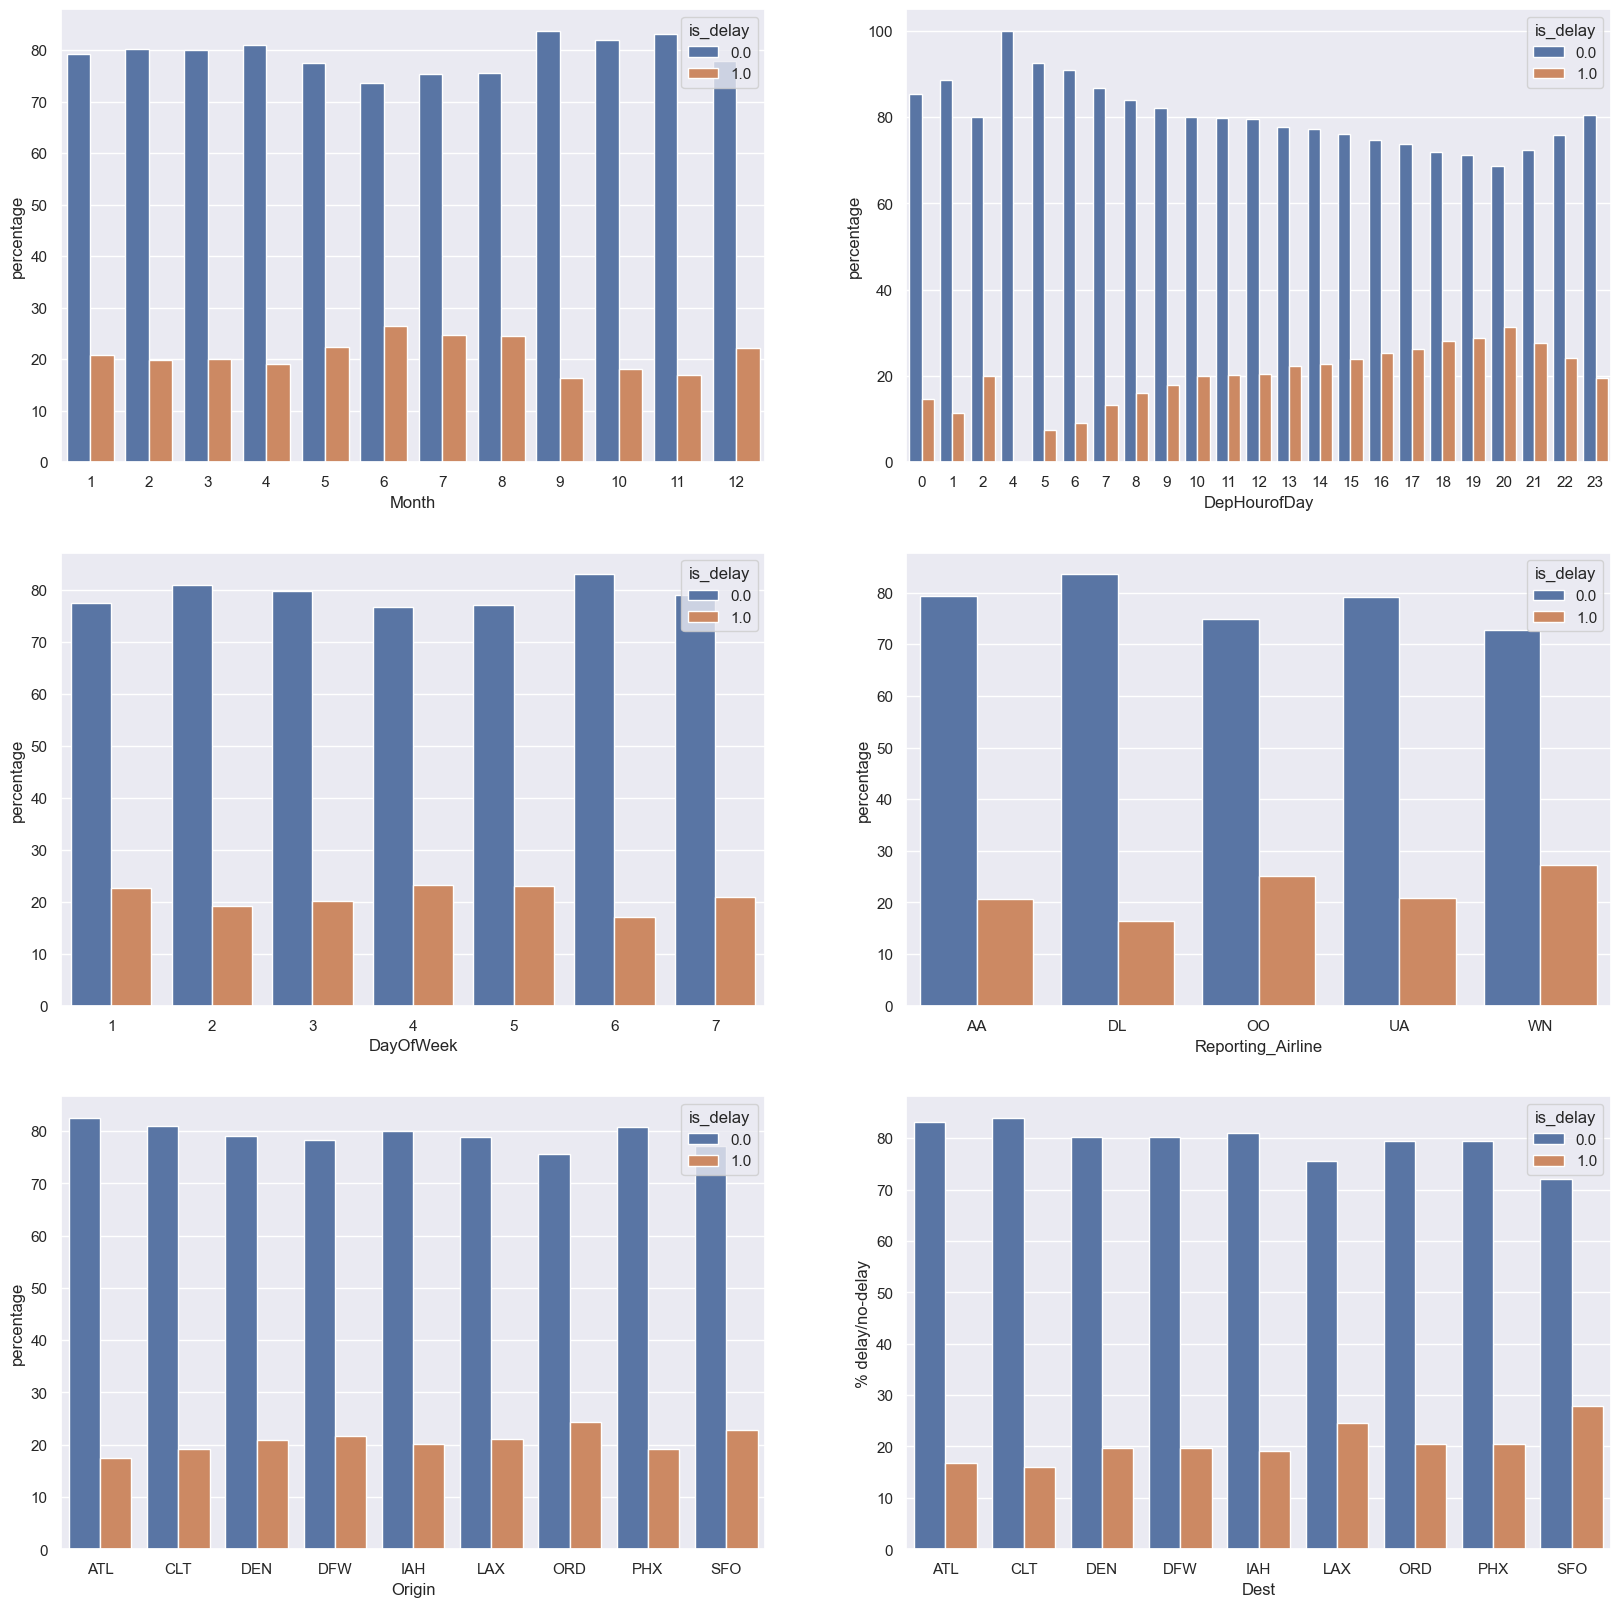

In [25]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

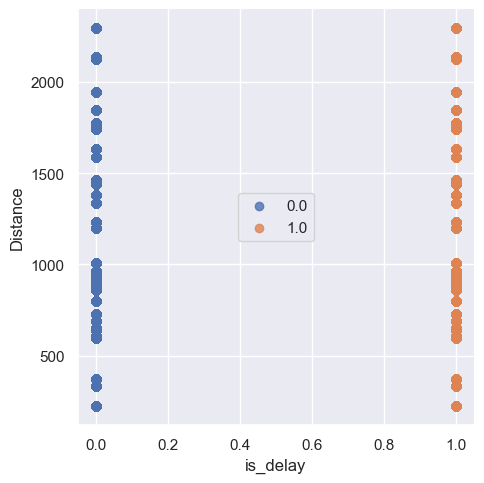

In [26]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

1. Which months have the most delays?
   - June (Month 6) is the most delay of the month, following by July (Month 7) and August (Month 8)

2. What time of the day has the most delays?
   - Time of the day hhas the most delays is 20:00 (8PM), following by 21:00 (9PM) and 22:00 (10PM)

3. What day of the week has the most delays?
   - Monday, Thursday and Friday are the most day delay of the week. It is very hard just to see by eyes because all of them are exactly similar

4. Which airline has the most delays?
   - The airline has the most delays is WN
   - Number two is OO

5. Which origin and destination airports have the most delays?
   - Origin is ORD
   - Dest is SFO

6. Is flight distance a factor in the delays?
   - The scatter plot suggests that flight distance doesn’t show a clear or direct correlation with delays. Both delayed (is_delay = 1.0) and non-delayed (is_delay = 0.0) flights span similar distances, with delays occurring across both short and long distances.
   - This distribution implies that flight distance alone isn’t a strong indicator of whether a flight will be delayed. Other factors, like time of day, airline operations, or airport congestion, may play a more significant role in influencing delays than the distance of the flight.

### Features

Look at all the columns and what their specific types are.

In [27]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [28]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

In [29]:
data.shape

(1635590, 21)

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [30]:
# Create a copy of the original data
data_orig = data.copy()

# Drop the "Date" column if it exists
data_orig = data_orig.drop(columns=['Date'], errors='ignore')

# Select and filter columns to create the final dataset
data = data_orig[['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                  'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']]

# Define categorical columns and convert to category type
categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')
    
# Splitting "Treat DepHourofDay" into Bucket as:
# Morning: 4AM - 12PM
# Afternoon: 12PM - 4PM
# Evening: 4PM - 8PM
# Night: 8PM - 4AM

# Define time-of-day buckets for DepHourofDay
def assign_time_of_day(hour):
    if 4 <= hour <12:
        return 'Morning'
    elif 12 <= hour <16:
        return 'Afternoon'
    elif 16 <= hour <20:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create the 'DepPeriodOfDay' column
data['DepHourofDay'] = data['DepHourofDay'].apply(assign_time_of_day).astype('category')

# Print data to check again
print(data)


         is_delay Quarter Month DayofMonth DayOfWeek Reporting_Airline Origin  \
0             0.0       1     1         26         7                DL    ATL   
1             0.0       1     1         26         7                DL    DFW   
2             0.0       1     1         26         7                DL    ATL   
3             0.0       1     1         26         7                DL    ATL   
4             0.0       1     1         26         7                DL    PHX   
...           ...     ...   ...        ...       ...               ...    ...   
1658125       0.0       3     9         11         2                WN    DEN   
1658126       0.0       3     9         11         2                WN    DEN   
1658127       1.0       3     9         11         2                WN    DEN   
1658128       0.0       3     9         11         2                WN    DEN   
1658129       0.0       3     9         11         2                WN    DEN   

        Dest  Distance DepH

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [31]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns, axis=1, inplace=True)

print(data.head())

   is_delay  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0       0.0     689.0      False      False      False    False    False   
1       0.0     731.0      False      False      False    False    False   
2       0.0    1199.0      False      False      False    False    False   
3       0.0    1587.0      False      False      False    False    False   
4       0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_Evening  DepHourofDay_Morning  \
0

Check the length of the dataset and the new columnms.

In [32]:
# Check the length (number of rows) of the dataset
print("Number of rows in the dataset:", len(data))

Number of rows in the dataset: 1635590


In [33]:
# print the shape to get both rows and columns
print("Shape of the dataset (rows, columns):", data.shape)

Shape of the dataset (rows, columns): (1635590, 75)


In [34]:
# Check the new columns added after one-hot encoding
print("New columns in the dataset after one-hot encoding:")
print(data.columns)

New columns in the dataset after one-hot encoding:
Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [35]:
data.rename(columns={'is_delay': 'target'}, inplace=True)

In [36]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
data.to_csv('./data/combined_csv_v1.csv', index=False)

# note this combined file will be used in part B

In [37]:
data.shape

(1635590, 75)

In [38]:
data.columns

Index(['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6',
       'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10',
       'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14',
       'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18',
       'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22',
       'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30',
       'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL',
       'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN',
       'Origin_CLT', 'Origin_DEN', '

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [39]:
# Drop unnessary features and split data into features (x) and target (y)
X = data.drop(columns=['target'])
y = data['target']


In [40]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Baseline classification model

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Print Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
print("Baseline Logistic Regression Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Baseline Logistic Regression Accuracy: 0.7894582383115573
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    258234
         1.0       0.52      0.00      0.00     68884

    accuracy                           0.79    327118
   macro avg       0.66      0.50      0.44    327118
weighted avg       0.73      0.79      0.70    327118

Confusion Matrix:
 [[258108    126]
 [ 68746    138]]


## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, target_predicted)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    

In [43]:
from sklearn.metrics import roc_curve, auc

def plot_roc(test_labels, target_predicted_proba):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(test_labels, target_predicted_proba)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

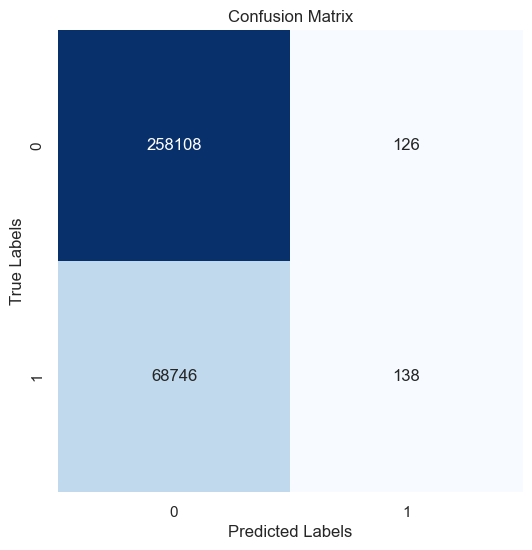

Accuracy: 0.79
Precision: 0.52
Recall: 0.00
Specificity: 1.00


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Call the plot_confusion_matrix function
plot_confusion_matrix(y_test, y_pred)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Print all metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

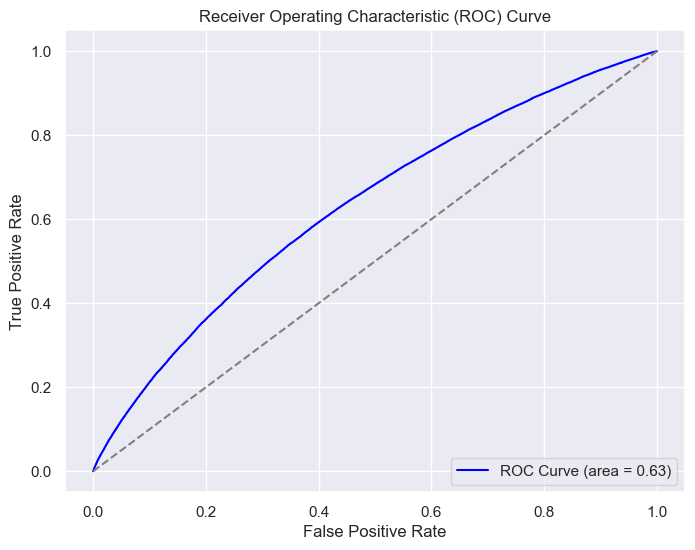

Accuracy: 0.79
Precision: 0.52
Recall: 0.00
Specificity: 1.00


In [45]:
# Get the predicted probabilities for the positive class (1) using the trained model
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # This provides the probabilities for class 1 (delayed)

# Call the plot_roc function
plot_roc(y_test, y_pred_proba)

#  Calculate and print evaluation statistics
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Specificity calculation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


- The baseline logistic regression model shows a significant issue with class imbalance, heavily favoring the majority class (no delay) and underperforming on the minority class (delays). While it achieves high accuracy in predicting no-delay cases, with 258,080 true negatives and only 154 false positives, it has difficulty identifying delays, resulting in 68,677 false negatives and only 207 true positives. This imbalance leads to very low recall and F1-score for delay predictions, highlighting the model’s bias towards predicting no delay. To improve its performance, it will be necessary to address the imbalance through resampling techniques, class weighting, or exploring more advanced models that can better capture delay patterns.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


https://github.com/Boyboy87/dsts-final-assignment-u3251397.git 

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [46]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

- Bad weather conditions like rain, strong winds, and snow can heavily disrupt flight schedules by affecting visibility, runway conditions, and air traffic control. To evaluate weather's impact on delays, we could gather historical weather data alongside flight delay records, analyze correlations between specific weather conditions and delay rates, and build predictive models that include weather factors. This would allow us to quantify weather’s role in delays and provide a clearer view of how adverse conditions impact flight punctuality.

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [47]:
import pandas as pd

# Load the weather data
weather = pd.read_csv('./data/daily-summaries-2024-10-31T19-26-09.csv')  # Adjust the path if necessary

# List of weather stations and corresponding airports
stations = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

# Create a mapping dictionary from stations to airports
station_map = dict(zip(stations, airports))

# Map the 'STATION' column in weather data to corresponding airports using the station_map
weather['airport'] = weather['STATION'].map(station_map)

# Display the first few rows to verify the 'airport' column
weather.head()


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX


Create another column called `MONTH` from the `DATE` column.

In [48]:
# Extract the month as a string from the 'DATE' column by splitting on '-'
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])

# Display the first few rows to verify
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [49]:
# Fill missing values in SNOW and SNWD columns with 0
weather['SNOW'].fillna(0, inplace=True)  # Assuming missing values mean no snow
weather['SNWD'].fillna(0, inplace=True)  # Assuming missing values mean no snow depth

# Check for any remaining missing values in the dataset
weather.isna().sum()


STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [50]:
import numpy as np

# Generate an array of indices for the DataFrame
idx = np.array([i for i in range(len(weather))])

# Get the indices of rows with missing values for TAVG, TMAX, and TMIN
TAVG_idx = idx[weather['TAVG'].isna()]
TMAX_idx = idx[weather['TMAX'].isna()]
TMIN_idx = idx[weather['TMIN'].isna()]

# Print the indices for missing values in TAVG
TAVG_idx


array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [51]:
# Group by 'STATION' to calculate the mean for TAVG, TMAX, and TMIN based on the specific weather station
weather_impute = weather.groupby(['STATION']).agg({'TAVG': 'mean', 'TMAX': 'mean', 'TMIN': 'mean'}).reset_index()

# Display the first two rows to verify the result
weather_impute.head(2)


,STATION,TAVG,TMAX,TMIN
0,USW00003017,112.931445,190.020263,32.978642
1,USW00003927,198.463308,256.026287,143.678532


Merge the mean data with the weather data.

In [52]:
# Merge weather data with the imputed mean data for TAVG, TMAX, and TMIN
weather = pd.merge(weather, weather_impute, how='left', on=['STATION']) \
    .rename(columns={
        'TAVG_y': 'TAVG_AVG',
        'TMAX_y': 'TMAX_AVG',
        'TMIN_y': 'TMIN_AVG',
        'TAVG_x': 'TAVG',
        'TMAX_x': 'TMAX',
        'TMIN_x': 'TMIN'
    })

# Display the first few rows to verify the merged data
weather.head()


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG
0,USW00023174,2014-01-01,16,0,0.0,0.0,131.0,178.0,78.0,LAX,01,181.254655,224.636364,146.18839
1,USW00023174,2014-01-02,22,0,0.0,0.0,159.0,256.0,100.0,LAX,01,181.254655,224.636364,146.18839
2,USW00023174,2014-01-03,17,0,0.0,0.0,140.0,178.0,83.0,LAX,01,181.254655,224.636364,146.18839
3,USW00023174,2014-01-04,18,0,0.0,0.0,136.0,183.0,100.0,LAX,01,181.254655,224.636364,146.18839
4,USW00023174,2014-01-05,18,0,0.0,0.0,151.0,244.0,83.0,LAX,01,181.254655,224.636364,146.18839


Check for missing values again.

In [53]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [54]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [55]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [56]:
sum(data.isna().any())

0

In [57]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [58]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [59]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                                    'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns, axis=1, inplace=True)

data.head()


,is_delay,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,False,False,True,False,False,False,False,False,False,False
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False


### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [60]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

In [61]:
print(data.columns)

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [62]:
# Rename the 'is_delay' column to 'target'
data.rename(columns={'is_delay': 'target'}, inplace=True)

# Display the first few rows to verify the column name change
data.head()


,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,False,False,True,False,False,False,False,False,False,False
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [63]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
data.to_csv('./data/combined_csv_v2.csv', index=False)

# Print
print("The new combined CSV file (combined_csv_v2.csv) has been saved.")

# note this combined file will be also used in part B

The new combined CSV file (combined_csv_v2.csv) has been saved.


In [64]:
data.shape

(1635590, 86)

Create the training and testing sets again.

In [65]:
# Convert all boolean values in the DataFrame to 0 and 1
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Display the first few rows to verify the changes
data.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(columns=['target'])
y = data['target']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Display the shapes of the training and testing sets to verify
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Testing set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Training set: X_train shape: (1308472, 85), y_train shape: (1308472,)
Testing set: X_test shape: (327118, 85), y_test shape: (327118,)


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [67]:
# Instantiate another logistic regression model
from sklearn.linear_model import LogisticRegression

# Instantiate a new logistic regression model
classifier2 = LogisticRegression(max_iter=1000, random_state=0) 

# Fit the model to the training data
classifier2.fit(X_train, y_train)



LogisticRegression(max_iter=1000, random_state=0)

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred = classifier2.predict(X_test)
y_pred_proba = classifier2.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


Accuracy: 0.7920261190151566
Precision: 0.5529061102831595
Recall (Sensitivity): 0.06463039312467336
Specificity: 0.9860591556495272
ROC AUC: 0.6717983751264514


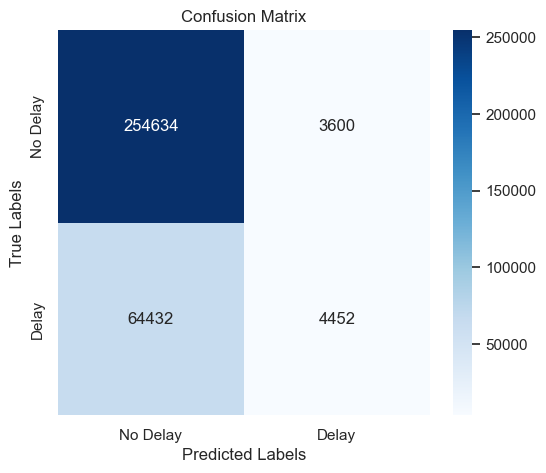

In [69]:

# Sensitivity (Recall) and Specificity
sensitivity = recall  # Recall is the sensitivity
conf_matrix = confusion_matrix(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", sensitivity)
print("Specificity:", specificity)
print("ROC AUC:", roc_auc)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


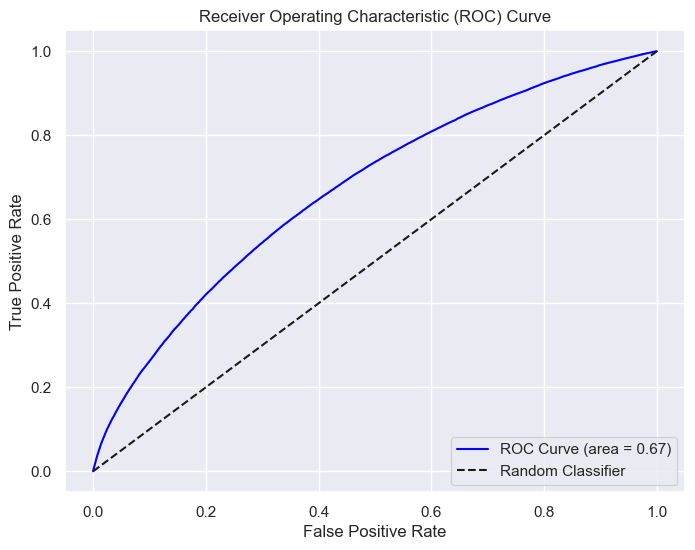

ROC AUC: 0.6717983751264514


In [70]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (area = {:.2f})".format(roc_auc), color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
print("ROC AUC:", roc_auc)

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

- Yes, by adding the extra data I can see the different result as explain below:
1. True Positive and False Positive Rates: In the second confusion matrix, there is a significant improvement in identifying the "delay" class (True Positive: 4,452 compared to 207 in the first matrix). This improvement is accompanied by a higher number of correctly predicted delays, although it also introduces more false positives (3,600 vs. 154).

2. False Negative Reduction: The false negatives (incorrectly predicting "no delay" when there was a delay) have decreased from 68,677 in the first matrix to 64,432 in the second. This indicates that the model is catching more actual delays, even if it still has a high number of missed delays.

3. Overall Class Balance Improvement: The second confusion matrix shows an improved balance in the model's ability to identify delays, possibly due to the inclusion of additional data (e.g., weather or other contextual features) that helps distinguish delays more effectively.

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

https://public.tableau.com/app/profile/chamroeunsathya.bin/viz/u3251397/Dashboard1?publish=yes

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

### Answers:

1. Based on these metrics, the model does not fully meet the business goal. Although the accuracy is 79.20%, the recall is extremly low, 6.4% which significantly impacts its usefulness for alerting customers about potential delays, as it fails to capture most delay cases. Therefore, We should focus on improving recall by adjusting the class imbalance, tuning the threshold for delay prediction, or experimenting with different models and features that could improve the model's ability to detect true delays.

2. The model saw substantial improvement as different data preparation and feature engineering methods were applied. Narrowing down the dataset to key features, such as top airports, airlines, and weather-related columns helped make the data more targeted and effective. Managing class imbalance through resampling or adjusting class weights, along with transforming features like DepHourofDay into categorical time slots, proved beneficial. Visualization and exploration further guided the process, highlighting important trends that shaped feature selection and model tuning.

3. I biggest challenges I encountered throughout this project:
   - I do not have muuch time to spend on the dataset because of my personal issue. Compare to Assignment 1 that I spent many times to read and understand about all instances and features, so I was confident to do the task. Time management is really very crucial for Data Science as I learnt from my final assignment.
   - I spent too much time on extracting and combining the large dataset, especially there are many compressed files as I am lack of experience on it.
   - Addressing class imbalance, as there were significantly more non-delay cases than delay cases
   - Selecting relevant features, as many factors could influence delays, but not all would contribute equally to predictive accuracy.

4. The three most important things I learned about ML whille completing this project:
   - Data Preprocessing: Addressing class imbalance, managing missing values, and handling categorical variables were essential steps that significantly boosted model performance.  
   - Impact of Feature Engineering: Converting raw data into useful features, like categorizing DepHourofDay and selecting major airports and airlines, enhanced the model's predictive power.  
   - Choosing the Right Evaluation Metrics: Prioritizing recall and precision over accuracy was critical to meet the business goal of predicting delays, especially considering the imbalance between delay and non-delay cases.